In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/data-science-bowl-2019/sample_submission.csv


In [2]:
import numpy as np
import pandas as pd
import shap
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from random import choice

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats

import gc
import json
pd.set_option('display.max_columns', 1000)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/kaggle/input/data-science-bowl-2019/train.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/data-science-bowl-2019/sample_submission.csv


In [3]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3

    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [4]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [5]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('/kaggle/input/data-science-bowl-2019/train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('/kaggle/input/data-science-bowl-2019/train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('/kaggle/input/data-science-bowl-2019/specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('/kaggle/input/data-science-bowl-2019/sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [6]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])

    train['hour'] = train['timestamp'].dt.hour
    test['hour'] = test['timestamp'].dt.hour
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [7]:
clip_time = {'Welcome to Lost Lagoon!':19,'Tree Top City - Level 1':17,'Ordering Spheres':61, 'Costume Box':61,
        '12 Monkeys':109,'Tree Top City - Level 2':25, 'Pirate\'s Tale':80, 'Treasure Map':156,'Tree Top City - Level 3':26,
        'Rulers':126, 'Magma Peak - Level 1':20, 'Slop Problem':60, 'Magma Peak - Level 2':22, 'Crystal Caves - Level 1':18,
        'Balancing Act':72, 'Lifting Heavy Things':118,'Crystal Caves - Level 2':24, 'Honey Cake':142, 'Crystal Caves - Level 3':19,
        'Heavy, Heavier, Heaviest':61}

In [8]:
def cnt_miss(df):
    cnt = 0
    for e in range(len(df)):
        x = df['event_data'].iloc[e]
        y = json.loads(x)['misses']
        cnt += y
    return cnt

In [9]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    # news features: time spent in each activity
    time_spent_each_act = {actv: 0 for actv in list_of_user_activities} # new
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    game_time_dict = {'Clip_gametime':0, 'Game_gametime':0, 'Activity_gametime':0, 'Assessment_gametime':0}

    # new features: time spent in each activity
    Assessment_mean_event_count = 0
    Game_mean_event_count = 0
    Activity_mean_event_count = 0
    mean_game_round = 0
    mean_game_duration = 0 
    mean_game_level = 0
    accumulated_game_miss = 0
    
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0

    accumulated_magma_game_correct = 0
    accumulated_tree_game_correct = 0
    accumulated_crystal_game_correct = 0

    accumulated_magma_game_incorrect = 0
    accumulated_tree_game_incorrect = 0
    accumulated_crystal_game_incorrect = 0

    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    clip_durations = []
    Activity_durations = []
    Game_durations = []

    time_diff_last = []

    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
        
    # last features
    sessions_count = 0
    # restore last session infowo
    session_last_time = []
    session_last_world = []
    assessment_titles = []

    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        assessment_titles.append(session_title) # new
        session_title_text = activities_labels[session_title]
        session_last_time.append(session['timestamp'].iloc[-1]) # new            
        if session_type == 'Clip':
            clip_durations.append((clip_time[activities_labels[session_title]]))
        
        if session_type == 'Activity':
            Activity_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            Activity_mean_event_count = (Activity_mean_event_count + session['event_count'].iloc[-1])/2.0
        if session_type == 'Game':
            Game_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            Game_mean_event_count = (Game_mean_event_count + session['event_count'].iloc[-1])/2.0
            
            session_last_world.append(session['world'].iloc[-1]) # new
        # pos
        #MAGMAPEAK :  ['73757a5e', '2b9272f4', '77ead60d', '4d911100', '6f4adc4b', '55115cbd', 'e3ff61fb', '709b1251']
        #TREETOPCITY :  ['daac11b0', '1f19558b', '9b4001e4', '58a0de5c', '3ddc79c3', 'e720d930']
        #CRYSTALCAVES :  ['47026d5f', 'cb6010f8', 'c7fe2a55', 'a8a78786', '3afde5dd', 'e5c9df6f', '250513af', 'cf7638f3']
        #neg
        #MAGMAPEAK :  ['d88e8f25', 'ac92046e', 'e5734469', '89aace00', '90ea0bac', '5859dfb6', '9de5e594', '28a4eb9a']
        #TREETOPCITY :  ['c277e121', 'd45ed6a1', '7423acbc', 'e04fb33d', '44cb4907', '8b757ab8']
        #CRYSTALCAVES :  ['0330ab6a', '2230fab4', '1af8be29', '3bf1cf26', '907a054b', 'c51d8688', '763fc34e', 'e57dd7af']
            
            magma_true_attempts = session.loc[session['event_id'].isin(['73757a5e', '2b9272f4', '77ead60d', '4d911100', '6f4adc4b', '55115cbd', 'e3ff61fb', '709b1251'])].shape[0]
            magma_false_attempts = session.loc[session['event_id'].isin(['d88e8f25', 'ac92046e', 'e5734469', '89aace00', '90ea0bac', '5859dfb6', '9de5e594', '28a4eb9a'])].shape[0]    

            tree_true_attempts = session.loc[session['event_id'].isin(['daac11b0', '1f19558b', '9b4001e4', '58a0de5c', '3ddc79c3', 'e720d930'])].shape[0]
            tree_false_attempts = session.loc[session['event_id'].isin(['c277e121', 'd45ed6a1', '7423acbc', 'e04fb33d', '44cb4907', '8b757ab8'])].shape[0]         

            crystal_true_attempts = session.loc[session['event_id'].isin(['47026d5f', 'cb6010f8', 'c7fe2a55', 'a8a78786', '3afde5dd', 'e5c9df6f', '250513af', 'cf7638f3'])].shape[0]
            crystal_false_attempts = session.loc[session['event_id'].isin(['0330ab6a', '2230fab4', '1af8be29', '3bf1cf26', '907a054b', 'c51d8688', '763fc34e', 'e57dd7af'])].shape[0]         

            accumulated_magma_game_correct += magma_true_attempts
            accumulated_tree_game_correct += tree_true_attempts
            accumulated_crystal_game_correct += crystal_true_attempts

            accumulated_magma_game_incorrect += magma_false_attempts
            accumulated_tree_game_incorrect += tree_false_attempts
            accumulated_crystal_game_incorrect += crystal_false_attempts

            game_s = session[session.event_code == 2030]   
            misses_cnt = cnt_miss(game_s)
            accumulated_game_miss += misses_cnt
            
            try:
                game_round = json.loads(session['event_data'].iloc[-1])["round"]
                mean_game_round =  (mean_game_round + game_round)/2.0
            except:
                pass

            try:
                game_duration = json.loads(session['event_data'].iloc[-1])["duration"]
                mean_game_duration = (mean_game_duration + game_duration) /2.0
            except:
                pass
            
            try:
                game_level = json.loads(session['event_data'].iloc[-1])["level"]
                mean_game_level = (mean_game_level + game_level) /2.0
            except:
                pass
        #else:
        #    session_last_world.append(0) # new

        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            # features.update(game_time_dict.copy())
            features['installation_session_count'] = sessions_count
            features['hour'] = session['hour'].iloc[-1]
            features['Assessment_mean_event_count'] = Assessment_mean_event_count
            features['Game_mean_event_count'] = Game_mean_event_count
            features['Activity_mean_event_count'] = Activity_mean_event_count
            features['mean_game_round'] = mean_game_round
            features['mean_game_duration'] = mean_game_duration
            features['mean_game_level'] = mean_game_level
            features['accumulated_game_miss'] = accumulated_game_miss
            # new
            try:
              session_time_diff = (session['timestamp'].iloc[0] - session_last_time[-2]).total_seconds() / 60
            except:
              session_time_diff = 0
            # 마지막으로 한 게임이 마지막 과제랑 같은 world이면 1
            if session['world'].iloc[0] in session_last_world:
              game_assessment_world = 1
            else:
              game_assessment_world = 0

            if session_title in assessment_titles[:-1]:
              assessment_title = 1
            else:
              assessment_title = 0
            
            features['assessment_time_before_diff'] = session_time_diff
            features['game_assessment_world'] = game_assessment_world
            features['assessment_title'] = assessment_title
            
            features['accumulated_magma__game_correct'] = accumulated_magma_game_correct
            features['accumulated_magma_game_incorrect'] = accumulated_magma_game_incorrect
            features['accumulated_tree_game_correct'] = accumulated_tree_game_correct
            features['accumulated_tree_game_incorrect'] = accumulated_tree_game_incorrect
            features['accumulated_crystal_game_correct'] = accumulated_crystal_game_correct
            features['accumulated_crystal_game_incorrect'] = accumulated_crystal_game_incorrect

            variety_features = [('var_event_code', event_code_count),
                              #('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                 
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
                
            if clip_durations == []:
                features['Clip_duration_mean'] = 0
                features['Clip_duration_std'] = 0
            else:
                features['Clip_duration_mean'] = np.mean(clip_durations)
                features['Clip_duration_std'] = np.std(clip_durations)
                
            if Activity_durations == []:
                features['Activity_duration_mean'] = 0
                features['Activity_duration_std'] = 0
            else:
                features['Activity_duration_mean'] = np.mean(Activity_durations)
                features['Activity_duration_std'] = np.std(Activity_durations)
                
            if Game_durations == []:
                features['Game_duration_mean'] = 0
                features['Game_duration_std'] = 0
            else:
                features['Game_duration_mean'] = np.mean(Game_durations)
                features['Game_duration_std'] = np.std(Game_durations)
                
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            Assessment_mean_event_count = (Assessment_mean_event_count + session['event_count'].iloc[-1])/2.0
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                if col == 'event_id':
                  session2 = session.loc[session['event_id'].isin(list_of_event_id)]
                  num_of_session_count = Counter(session2[col])
                else:
                  num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
        game_time_dict[session_type+'_gametime'] = (game_time_dict[session_type+'_gametime'] + (session['game_time'].iloc[-1]/1000.0))/2.0    
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
       
        return all_assessments[-1]#, all_assessments[-2],all_assessments[:-2]
    
    return all_assessments

In [10]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)

    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title','game_assessment_world', 'assessment_title']
    return reduce_train, reduce_test, categoricals

In [11]:
def get_train_and_test_val(train, test):
    compiled_train = []
    compiled_test = []
    compiled_val = []
    #compiled_exp = []

    for i, (ins_id, user_sample) in enumerate(train.groupby('installation_id', sort=False)):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in test.groupby('installation_id', sort=False):
        test_data, val_data = get_data(user_sample, test_set=True)

        compiled_test.append(test_data)
        if val_data != []:
          #compiled_exp.append(exp_data)
          compiled_val += val_data
        else: 
          pass
        
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    reduce_val = pd.DataFrame(compiled_val)
    
    #reduce_exp = pd.DataFrame(compiled_exp)

    categoricals = ['session_title','game_assessment_world']
    return reduce_train, reduce_test, reduce_val,  categoricals

## 4. Preparation to modelling

In [12]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [13]:
list_of_event_id2 = ['3babcb9b', '7f0836bf', 'ab3136ba', 'bbfe0445', '33505eae',
       '15f99afc', '795e4a37', 'a1e4395d', '1375ccb7', '363d3849',
       '923afab1', '67439901', '71fe8f75', 'a29c5338', 'ea321fb1',
       '0d1da71f', 'f7e47413', '3dcdda7f', 'df4940d3', '2dcad279',
       'bdf49a58', 'a52b92d5', '6cf7d25c', '1bb5fbdb', '84b0e0c8',
       '7ab78247', '7ec0c298', 'b2dba42b', '69fdac0a', '49ed92e9',
       'bd701df8', '832735e1', '2a512369', '5154fc30', '9e4c8c7b',
       'beb0a7b9', '0413e89d', '0a08139c', 'b80e5e84', 'f71c4741',
       '56cd3b43', 'b88f38da', '828e68f9', 'f28c589a', '15eb4a7d',
       '3ccd3f02', 'a1bbe385', '8d7e386c'] # 잘못된 행동일 때 나오는 이벤트인 것 같지만 Incorrect는 아님. 애매함.

In [14]:
reduce_train = reduce_train.drop(list(set(list_of_event_id) - set(list_of_event_id2)), axis=1)
reduce_test = reduce_test.drop(list(set(list_of_event_id) - set(list_of_event_id2)), axis=1)

In [15]:
target = reduce_train['accuracy_group']

0.0026939774600629332


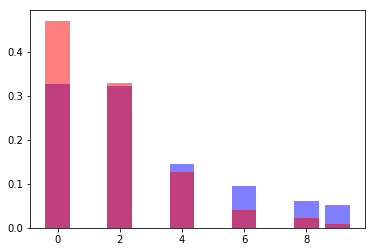

0.0026939774600629332

In [16]:
def stract_hists(feature, train=reduce_train, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    #val_data = val[feature]

    if adjust:
        test_data *= train_data.mean() / test_data.mean()
        #val_data *= test_data.mean() / val_data.mean()

    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    #val_data = np.clip(val_data, 0, perc_90)
    
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    #val_hist = np.histogram(val_data, bins=n_bins)[0] / len(val_data)
    msre_t = mean_squared_error(train_hist, test_hist)#, mean_squared_error(train_hist, val_hist)
    if plot:
        print(msre_t)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre_t
stract_hists('Magma Peak - Level 1_2000', adjust=False, plot=True)

In [17]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [18]:
to_exclude = [] 
ajusted_test = reduce_test.copy()
#ajusted_val = reduce_val.copy()

for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        #data = ajusted_val[feature] 
        #val_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            #ajust_factor2 = train_mean / val_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor # 점수는 조금 오른다지만 너무 리스키하고 납득이 잘 안됨..
                #ajusted_val[feature] *= ajust_factor2
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

acc_Cart Balancer (Assessment) -0.04020325710970116 -0.47065833333333346 0.006732930476733109
Crystals Rule_2010 0.0 0.0
Dino Drink_4080 0.0009044657998869418 0.0
Pan Balance_4080 0.0013001695873374789 0.0
Dino Dive_4080 0.0002826455624646693 0.0
Fireworks (Activity)_4080 0.0013566986998304127 0.0
Watering Hole (Activity)_2010 0.0007348784624081402 0.0
Pan Balance_2010 0.0 0.0
Cart Balancer (Assessment)_4080 0.007292255511588468 0.0
Mushroom Sorter (Assessment)_4090 0.17382702091577162 0.008 0.0
Egg Dropper (Activity)_4080 0.01978518937252685 0.0
Chest Sorter (Assessment)_4080 0.012832108535895986 0.0
Happy Camel_4080 0.0008479366873940079 0.0
Air Show_4080 0.0 0.0
Leaf Leader_4080 0.0004522328999434709 0.0
Bubble Bath_4090 0.14703222159412097 0.008 0.0
Bug Measurer (Activity)_4080 0.008988128886376484 0.0
Sandcastle Builder (Activity)_2010 0.0 0.0
Bottle Filler (Activity)_2010 0.0 0.0
Scrub-A-Dub_4080 0.0 0.0
Mushroom Sorter (Assessment)_4080 0.04392312040700961 0.0
Bubble Bath_4080 0

In [19]:
features = [x for x in features if x not in to_exclude]
reduce_train[features].shape

(17690, 563)

In [20]:
reduce_train[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Columns: 563 entries, Clip to accumulated_actions
dtypes: float64(21), int64(542)
memory usage: 76.0 MB


## Model building & prediction

In [21]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features2, categoricals=[], n_splits=10, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        #self.val_df = val_df
        #self.train_val_df = pd.concat([train_df, val_df], axis=0).reset_index(drop=True)
        #self.exp_df = exp_df
        self.features2 = features2
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.group = 'installation_id'
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.score, self.model, self.oof_pred = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        #cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        cv = GroupKFold(n_splits=self.n_splits)
        
        return cv.split(self.train_df, self.train_df[self.target], self.train_df[self.group])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train2), ))
        y_pred = np.zeros((len(reduce_test), ))
        #out_of_fold_predictions = np.zeros((ajusted_val.shape[0], 2))
        #feature_importances = pd.DataFrame()

        for fold, (train_idx, val_idx) in enumerate(self.cv):
            #x_train, x_val = pd.concat([self.val_df[self.features].iloc[train_idx], self.train_df[self.features]], axis=0), self.val_df[self.features].iloc[val_idx]
            #y_train, y_val = pd.concat([self.val_df[self.target][train_idx], self.train_df[self.target]], axis=0), self.val_df[self.target][val_idx]
            x_train, x_val = self.train_df[self.features2].iloc[train_idx], self.train_df[self.features2].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features2])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, loss_score, model, oof_pred

In [22]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                  'bagging_fraction': 0.8369424922415609,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.8329390718407614,
                    'subsample_freq': 1,
                    'learning_rate': 0.008, # learning_rate_lgb,
                    'feature_fraction':  0.5682096494749166,
                    'max_depth': 15, # max_depth_lgb,
                    'lambda_l1': 0.19515477895583855,
                    'lambda_l2':  1.8977710745066665,
                    'early_stopping_rounds': 200
                    }
        return params


In [23]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'colsample_bytree': 0.7395,                 
            'learning_rate': 0.008, #learning_rate_xgb,
            'max_depth': 3, # max_depth_xgb,
            'subsample': 0.5624,
            'objective':'reg:squarederror',
            'min_child_weight':3,
            'gamma':0.25,
            'n_estimators':5000}

        return params

In [24]:
reduce_train2 = reduce_train.copy()
reduce_train2.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in reduce_train2.columns]
ajusted_test2 = ajusted_test.copy()
ajusted_test2.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in ajusted_test2.columns]

features2 = features.copy()
features2 = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in features2]

Found `n_estimators` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 1.0784	valid_1's rmse: 1.13896
[200]	training's rmse: 1.00049	valid_1's rmse: 1.06295
[300]	training's rmse: 0.96176	valid_1's rmse: 1.03214
[400]	training's rmse: 0.934312	valid_1's rmse: 1.01599
[500]	training's rmse: 0.915109	valid_1's rmse: 1.00829
[600]	training's rmse: 0.899374	valid_1's rmse: 1.00495
[700]	training's rmse: 0.88597	valid_1's rmse: 1.00303
[800]	training's rmse: 0.873676	valid_1's rmse: 1.00185
[900]	training's rmse: 0.862083	valid_1's rmse: 1.0016
[1000]	training's rmse: 0.851261	valid_1's rmse: 1.00103
[1100]	training's rmse: 0.840918	valid_1's rmse: 1.00054
[1200]	training's rmse: 0.83113	valid_1's rmse: 1.00088
[1300]	training's rmse: 0.821673	valid_1's rmse: 1.00068
Early stopping, best iteration is:
[1121]	training's rmse: 0.838795	valid_1's rmse: 1.0003
Partial score of fold 0 is: 0.6137033591499568
Training until validation scores don't improve for 200 rounds
[100]	trainin

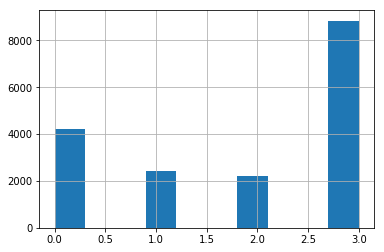

In [25]:
lgb_model = Lgb_Model(reduce_train2, ajusted_test2, features2, categoricals=categoricals)

[0]	train-rmse:1.87203	val-rmse:1.76647
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.26493	val-rmse:1.23948
[200]	train-rmse:1.08156	val-rmse:1.09565
[300]	train-rmse:1.02704	val-rmse:1.05589
[400]	train-rmse:1.00631	val-rmse:1.03994
[500]	train-rmse:0.994783	val-rmse:1.03171
[600]	train-rmse:0.986817	val-rmse:1.0267
[700]	train-rmse:0.980333	val-rmse:1.02263
[800]	train-rmse:0.975119	val-rmse:1.01924
[900]	train-rmse:0.970724	val-rmse:1.01714
[1000]	train-rmse:0.966712	val-rmse:1.01538
[1100]	train-rmse:0.962923	val-rmse:1.0131
[1200]	train-rmse:0.959399	val-rmse:1.01189
[1300]	train-rmse:0.956197	val-rmse:1.0106
[1400]	train-rmse:0.953037	val-rmse:1.01002
[1500]	train-rmse:0.949984	val-rmse:1.00973
[1600]	train-rmse:0.947151	val-rmse:1.00961
[1700]	train-rmse:0.944444	val-rmse:1.00812
[1800]	train-rmse:0.941843	val-rmse:1.0083
Stopping. Best iteration:
[1752]	train-rmse

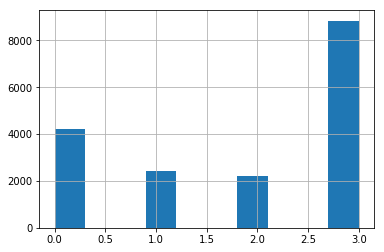

In [26]:
xgb_model = Xgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

## Stacking

fold 0, loss= ('cappa', 0.5910366692044589, True)
fold 1, loss= ('cappa', 0.5657502150464104, True)
fold 2, loss= ('cappa', 0.566867242658134, True)
fold 3, loss= ('cappa', 0.5710679497768893, True)
fold 4, loss= ('cappa', 0.5586052869242597, True)
fold 5, loss= ('cappa', 0.6002609276975831, True)
fold 6, loss= ('cappa', 0.5731656215491403, True)
fold 7, loss= ('cappa', 0.602311201341908, True)
fold 8, loss= ('cappa', 0.5659303072976976, True)
fold 9, loss= ('cappa', 0.5726982815323498, True)
fold 10, loss= ('cappa', 0.6040554072096128, True)
fold 11, loss= ('cappa', 0.5594159650431632, True)
fold 12, loss= ('cappa', 0.5993985875082763, True)
fold 13, loss= ('cappa', 0.5937050956118051, True)
fold 14, loss= ('cappa', 0.5898357003620162, True)
fold 15, loss= ('cappa', 0.5757016248153619, True)
fold 16, loss= ('cappa', 0.5840666072621965, True)
fold 17, loss= ('cappa', 0.5710007144034732, True)
fold 18, loss= ('cappa', 0.6320220127499592, True)
fold 19, loss= ('cappa', 0.5452369294380066

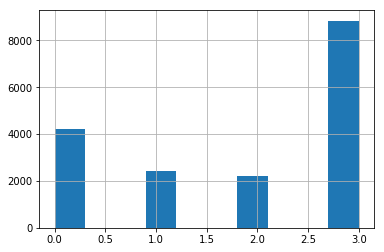

In [27]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
kfold = KFold(n_splits=20)
val_pred_data = np.column_stack([lgb_model.oof_pred,  xgb_model.oof_pred])
test_pred_data = np.column_stack([lgb_model.y_pred,  xgb_model.y_pred])

val_final_pred = np.zeros(len(val_pred_data),)
stk_final_pred = np.zeros(len(test_pred_data),)

for fold, (trn_idx, val_idx) in enumerate(kfold.split(val_pred_data, reduce_train['accuracy_group'])):
  x_train, x_val = val_pred_data[trn_idx], val_pred_data[val_idx]
  y_train, y_val = reduce_train['accuracy_group'].iloc[trn_idx], reduce_train['accuracy_group'].iloc[val_idx]

#train_test_split(val_pred_data, reduce_train_val['accuracy_group'], test_size=0.05, random_state=42)                                
  meta_model = linear_model.Lasso(alpha=0.001, max_iter=10000)
  meta_model.fit(x_train, y_train)
  val_sub_pred = meta_model.predict(x_val)
  val_final_pred[val_idx]= val_sub_pred 
  stk_final_pred += meta_model.predict(test_pred_data).reshape(stk_final_pred.shape) / 20
  print('fold {}, loss= {}'.format(fold, eval_qwk_lgb_regr(y_val, val_sub_pred)))
print('Total loss = ',eval_qwk_lgb_regr(reduce_train['accuracy_group'], val_final_pred))
print(stk_final_pred.shape)

## Ensemble

In [28]:
predictions = []
all_pred = np.column_stack([lgb_model.oof_pred,  xgb_model.oof_pred, val_final_pred])
n_model = 3
for i in range(n_model):
  predictions.append(all_pred[:,i])

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def mae_loss_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = 0
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight*prediction

    return mean_squared_error(reduce_train['accuracy_group'], final_prediction)

In [30]:
from scipy.optimize import minimize
best_scores = []
weights = []
iteration = 5000 # 여러 번 구한 가중치 값 중 최고점을 선택
for i in range(iteration):
    starting_values = np.random.uniform(size=len(predictions))
    bounds = [(0,1)]*len(predictions)
    cons = ({'type':'eq','fun':lambda w: 1-sum(w)})

    res = minimize(mae_loss_func, 
            starting_values, 
            method = 'SLSQP', 
            bounds = bounds, 
            constraints = cons,
            options={'maxiter': 100000})
    best_scores.append(res['fun'])
    weights.append(res['x'])

#best_scores = np.max(best_scores)
#weights = (weights / iteration)
weights = weights[np.argmin(best_scores)]
print('Ensamble Score: {}'.format(np.min(best_scores)))
print('Best Weights: {}'.format(weights))

Ensamble Score: 0.9812951420099422
Best Weights: [0.13673128 0.         0.86326872]


('cappa', 0.5861909640479818, True)

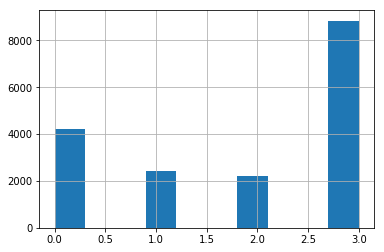

In [31]:
# train_set의 예측 결과
eval_qwk_lgb_regr(reduce_train['accuracy_group'], (weights[0]*lgb_model.oof_pred\
                                                   + weights[1]*xgb_model.oof_pred\
                                                   + weights[2]*val_final_pred))

## Finally decide the bound

In [32]:
final_pred = (weights[0]*lgb_model.y_pred  + weights[1] * xgb_model.y_pred + weights[2]*stk_final_pred)

{0: 1.3107923496844864, 1: 1.715718421565678, 2: 1.9796581175118442}


3    0.500
0    0.239
1    0.136
2    0.125
Name: accuracy_group, dtype: float64

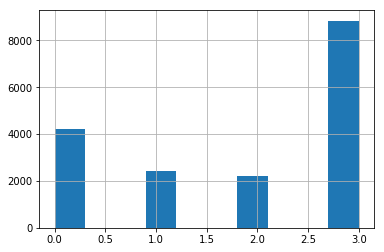

In [33]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

sample_submission['accuracy_group'] = final_pred.astype(int)
sample_submission.to_csv('submission.csv', index=False)
sample_submission['accuracy_group'].value_counts(normalize=True)